In [1]:
!pip install torch transformers rdkit torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 47.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 63.9 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import BertConfig, BertModel, BertLMHeadModel
from torch.optim import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup
from rdkit import Chem
import copy
import math
from torch.utils.data import DataLoader, Dataset

2026-01-05 13:44:33.794569: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767620673.958083      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767620674.003224      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767620674.380159      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767620674.380218      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767620674.380221      24 computation_placer.cc:177] computation placer alr

In [3]:
from torch_geometric.data import InMemoryDataset
class PubChemDataset(InMemoryDataset):
    def __init__(self, path):
        super(PubChemDataset, self).__init__()
        self.data, self.slices = torch.load(path, weights_only=False)
    
    def __getitem__(self, idx):
        return self.get(idx)

In [4]:
raw_dataset = PubChemDataset('/kaggle/input/pubchem324k-dataset/train.pt')

In [5]:
ldmol_dataset = []
for data in raw_dataset:
    ldmol_dataset.append({
            'smiles': data.smiles,
            'text': data.text
        })

In [6]:
print(ldmol_dataset[0:2])

[{'smiles': 'C1=CC=C(C=C1)C(CN)O', 'text': 'The molecule is the simplest member of the class of phenylethanolamines that is 2-aminoethanol bearing a phenyl substituent at the 1-position. The parent of the phenylethanolamine class. It has a role as a human metabolite. It is a conjugate base of a phenylethanolaminium.\nThe molecule is a natural product found in Peucedanum palustre, Pseudo-nitzschia multistriata, and other organisms with data available.\nThe molecule is also used in chemical industry.'}, {'smiles': 'CC(=C)C(CC1=C2C(=C(C3=C1OC4=C(C3=O)C=C(C=C4)O)O)C=CC(O2)(C)C)OO', 'text': 'The molecule is a member of the class of pyranoxanthones that is 2H,6H-pyrano[3,2-b]xanthen-6-one substituted by a 2-hydroperoxy-3-methylbut-3-en-1-yl moiety at position 12, hydroxy groups at positions 5 and 8 and geminal methyl groups at position 2. It is isolated from the stem bark of Calophyllum brasiliense and exhibits significant inhibitory activity against 12-O-tetradecanoylphorbol-13-acetate indu

In [7]:
class SMILESDataset_pretrain(Dataset):
    def __init__(self, ldmol_dataset, data_length=None, shuffle=False, is_train=True):
        """
        Args:
            ldmol_dataset: List of dictionaries containing 'smiles' and 'text' keys.
            data_length: Optional list/tuple [start_index, end_index].
            shuffle: Whether to shuffle the list on initialization.
            is_train: If True, enables stereoisomer pairing (augmentation).
        """
        # Slice the list if data_length is provided
        if data_length is not None:
            self.data = ldmol_dataset[data_length[0]:data_length[1]]
        else:
            self.data = list(ldmol_dataset)

        if shuffle:
            random.shuffle(self.data)

        self.train = is_train

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        # Access the smiles string from the dictionary
        smiles = self.data[index]['smiles']
        smiles2 = smiles
        
        try:
            mol = Chem.MolFromSmiles(smiles)
            if mol:
                # Enumerate possible 3D configurations
                sc_list = list(EnumerateStereoisomers(mol))
                
                if self.train and len(sc_list) > 1:
                    # Pick two different isomers for contrastive pre-training
                    mol_a, mol_b = random.sample(sc_list, k=2)
                    smiles = Chem.MolToSmiles(mol_a, canonical=True, isomericSmiles=True)
                    smiles2 = Chem.MolToSmiles(mol_b, canonical=True, isomericSmiles=True)
                else:
                    # Pick one random isomer
                    mol_selected = random.choice(sc_list)
                    smiles = Chem.MolToSmiles(mol_selected, canonical=True, isomericSmiles=True)
        except Exception as e:
            # If RDKit fails, fall back to the original string
            pass

        if self.train and smiles2 != smiles:
            # Output format: [CLS]isomer1Q[CLS]isomer2
            return f'[CLS]{smiles}Q[CLS]{smiles2}'
        
        return f'[CLS]{smiles}'

In [8]:
import random
train_ds = SMILESDataset_pretrain(ldmol_dataset, shuffle=True, is_train=True)

In [9]:
val_ds = SMILESDataset_pretrain(ldmol_dataset, is_train=False)

In [10]:
items = [train_ds[i] for i in range(0, 2)]
print(items)

['[CLS]OS(=O)(=O)[O-].[K+]', '[CLS]C1C=CN(C=C1C(=O)N)[C@H]2[C@@H]([C@@H]([C@H](O2)COP(=O)([O-])OP(=O)([O-])OC[C@@H]3[C@H]([C@H]([C@@H](O3)N4C=NC5=C(N=CN=C54)N)OP(=O)([O-])[O-])O)O)O']


In [11]:
from transformers.models.bert.configuration_bert import BertConfig

In [12]:
def get_bert_config():
    return BertConfig(
        vocab_size=300,
        hidden_size=1024,
        num_hidden_layers=12,
        num_attention_heads=16,
        intermediate_size=3072,
        hidden_act="gelu",
        hidden_dropout_prob=0.1,
        attention_probs_dropout_prob=0.1,
        max_position_embeddings=512,
        type_vocab_size=2,
        initializer_range=0.02
    )

In [13]:
class LDMolEncoder(nn.Module):
    def __init__(self, vocab_size=300, embed_dim=256, queue_size=16384, momentum=0.995, temp=0.07):
        super().__init__()
        
        # Now using the vocab_size passed from the training script
        bert_config = BertConfig(
            vocab_size=vocab_size, 
            hidden_size=768, 
            num_hidden_layers=6, 
            num_attention_heads=12, 
            intermediate_size=2048,
            hidden_act="gelu",
            max_position_embeddings=512
        )
        
        # Main Encoder
        self.encoder = BertModel(bert_config)
        self.proj = nn.Linear(768, embed_dim)
        
        # Momentum Encoder
        self.encoder_m = BertModel(bert_config)
        self.proj_m = nn.Linear(768, embed_dim)
        
        self.momentum = momentum
        self.temp = nn.Parameter(torch.ones([]) * temp)

        # Initialize momentum weights to match main encoder exactly
        self._copy_params()

        # MoCo Queue setup
        self.register_buffer("queue", F.normalize(torch.randn(embed_dim, queue_size), dim=0))
        self.register_buffer("queue_ptr", torch.zeros(1, dtype=torch.long))

    @torch.no_grad()
    def _copy_params(self):
        """Helper to initialize momentum weights."""
        for p, p_m in zip(self.encoder.parameters(), self.encoder_m.parameters()):
            p_m.data.copy_(p.data)
            p_m.requires_grad = False
        for p, p_m in zip(self.proj.parameters(), self.proj_m.parameters()):
            p_m.data.copy_(p.data)
            p_m.requires_grad = False

    @torch.no_grad()
    def _momentum_update(self):
        """Exponential Moving Average update of the momentum encoder."""
        for p, p_m in zip(self.encoder.parameters(), self.encoder_m.parameters()):
            p_m.data = p_m.data * self.momentum + p.data * (1. - self.momentum)
        for p, p_m in zip(self.proj.parameters(), self.proj_m.parameters()):
            p_m.data = p_m.data * self.momentum + p.data * (1. - self.momentum)

    @torch.no_grad()
    def _dequeue_and_enqueue(self, keys):
        batch_size = keys.shape[0]
        ptr = int(self.queue_ptr)
        
        # Replace the oldest keys in the queue
        self.queue[:, ptr:ptr + batch_size] = keys.T
        # Update pointer (circular buffer)
        self.queue_ptr[0] = (ptr + batch_size) % self.queue.shape[1]

    def forward(self, ids1, mask1, ids2, mask2):
        # 1. Encode View 1 with main encoder
        # We take the [CLS] token embedding (index 0)
        out1 = self.encoder(ids1, attention_mask=mask1).last_hidden_state[:, 0, :]
        feat1 = F.normalize(self.proj(out1), dim=-1)

        # 2. Encode View 2 with momentum encoder
        with torch.no_grad():
            self._momentum_update()
            out2 = self.encoder_m(ids2, attention_mask=mask2).last_hidden_state[:, 0, :]
            feat2_m = F.normalize(self.proj_m(out2), dim=-1)
            
            # Combine current keys with the historical queue
            feat_all = torch.cat([feat2_m.t(), self.queue.clone().detach()], dim=1)

        # 3. InfoNCE Loss
        # Matrix multiplication gives cosine similarity (since features are normalized)
        logits = feat1 @ feat_all / self.temp
        
        # Targets are 0 because the positive pair is always at the first index of feat_all
        targets = torch.zeros(logits.size(0), dtype=torch.long).to(ids1.device)
        loss = F.cross_entropy(logits, targets)
        
        # 4. Update memory bank
        self._dequeue_and_enqueue(feat2_m)
        
        return loss

In [14]:
def augment_single_smi(smi: str) -> str:
    smi = smi.strip().replace('[CLS]', '')
    mol = Chem.MolFromSmiles(smi)
    if not mol: return smi
    try:
        isomers = list(EnumerateStereoisomers(mol))
        mol = random.choice(isomers)
        return Chem.MolToSmiles(mol, doRandom=True, isomericSmiles=True)
    except:
        return smi

In [15]:
def sentence_randomize(description, only_one=False):
    """
    Splits text by newlines or periods and picks components randomly.
    Adapted for the newline-heavy structure in your dictionary example.
    """
    # Splitting by newline first since your data uses \n to separate paragraphs
    sentences = [s.strip() for s in description.replace('\n', '. ').split('. ') if s.strip()]
    
    if not sentences:
        return "no description."

    if only_one:
        return random.choice(sentences)
    
    # Return a random subset of sentences
    sample_size = random.randint(1, len(sentences))
    selected = random.sample(sentences, sample_size)
    return " ".join(selected)

In [16]:
import logging
import math
import numpy as np
import torch
from typing import Dict, Any

_logger = logging.getLogger(__name__)

In [17]:
class Scheduler:
    """ Parameter Scheduler Base Class """
    def __init__(self,
                 optimizer: torch.optim.Optimizer,
                 param_group_field: str,
                 noise_range_t=None,
                 noise_type='normal',
                 noise_pct=0.67,
                 noise_std=1.0,
                 noise_seed=None,
                 initialize: bool = True) -> None:
        self.optimizer = optimizer
        self.param_group_field = param_group_field
        self._initial_param_group_field = f"initial_{param_group_field}"
        if initialize:
            for i, group in enumerate(self.optimizer.param_groups):
                if param_group_field not in group:
                    raise KeyError(f"{param_group_field} missing from param_groups[{i}]")
                group.setdefault(self._initial_param_group_field, group[param_group_field])
        else:
            for i, group in enumerate(self.optimizer.param_groups):
                if self._initial_param_group_field not in group:
                    raise KeyError(f"{self._initial_param_group_field} missing from param_groups[{i}]")
        self.base_values = [group[self._initial_param_group_field] for group in self.optimizer.param_groups]
        self.metric = None
        self.noise_range_t = noise_range_t
        self.noise_pct = noise_pct
        self.noise_type = noise_type
        self.noise_std = noise_std
        self.noise_seed = noise_seed if noise_seed is not None else 42
        self.update_groups(self.base_values)

    def state_dict(self) -> Dict[str, Any]:
        return {key: value for key, value in self.__dict__.items() if key != 'optimizer'}

    def load_state_dict(self, state_dict: Dict[str, Any]) -> None:
        self.__dict__.update(state_dict)

    def get_epoch_values(self, epoch: int):
        return None

    def get_update_values(self, num_updates: int):
        return None

    def step(self, epoch: int, metric: float = None) -> None:
        self.metric = metric
        values = self.get_epoch_values(epoch)
        if values is not None:
            values = self._add_noise(values, epoch)
            self.update_groups(values)

    def step_update(self, num_updates: int, metric: float = None):
        self.metric = metric
        values = self.get_update_values(num_updates)
        if values is not None:
            values = self._add_noise(values, num_updates)
            self.update_groups(values)

    def update_groups(self, values):
        if not isinstance(values, (list, tuple)):
            values = [values] * len(self.optimizer.param_groups)
        for param_group, value in zip(self.optimizer.param_groups, values):
            param_group[self.param_group_field] = value

    def _add_noise(self, lrs, t):
        if self.noise_range_t is not None:
            if isinstance(self.noise_range_t, (list, tuple)):
                apply_noise = self.noise_range_t[0] <= t < self.noise_range_t[1]
            else:
                apply_noise = t >= self.noise_range_t
            if apply_noise:
                g = torch.Generator()
                g.manual_seed(self.noise_seed + t)
                if self.noise_type == 'normal':
                    while True:
                        noise = torch.randn(1, generator=g).item()
                        if abs(noise) < self.noise_pct:
                            break
                else:
                    noise = 2 * (torch.rand(1, generator=g).item() - 0.5) * self.noise_pct
                lrs = [v + v * noise for v in lrs]
        return lrs

In [18]:
class CosineLRScheduler(Scheduler):
    def __init__(self, optimizer, t_initial, t_mul=1., lr_min=0., decay_rate=1.,
                 warmup_t=0, warmup_lr_init=0, warmup_prefix=True, cycle_limit=0,
                 t_in_epochs=True, noise_range_t=None, noise_pct=0.67, noise_std=1.0,
                 noise_seed=42, initialize=True) -> None:
        super().__init__(optimizer, param_group_field="lr", noise_range_t=noise_range_t, 
                         noise_pct=noise_pct, noise_std=noise_std, noise_seed=noise_seed, initialize=initialize)
        self.t_initial, self.t_mul, self.lr_min = t_initial, t_mul, lr_min
        self.decay_rate, self.cycle_limit, self.warmup_t = decay_rate, cycle_limit, warmup_t
        self.warmup_lr_init, self.warmup_prefix, self.t_in_epochs = warmup_lr_init, warmup_prefix, t_in_epochs
        if self.warmup_t:
            self.warmup_steps = [(v - warmup_lr_init) / self.warmup_t for v in self.base_values]
            super().update_groups(self.warmup_lr_init)
        else:
            self.warmup_steps = [1 for _ in self.base_values]

    def _get_lr(self, t):
        if t < self.warmup_t:
            return [self.warmup_lr_init + t * s for s in self.warmup_steps]
        if self.warmup_prefix: t = t - self.warmup_t
        if self.t_mul != 1:
            i = math.floor(math.log(1 - t / self.t_initial * (1 - self.t_mul), self.t_mul))
            t_i = self.t_mul ** i * self.t_initial
            t_curr = t - (1 - self.t_mul ** i) / (1 - self.t_mul) * self.t_initial
        else:
            i = t // self.t_initial
            t_i, t_curr = self.t_initial, t - (self.t_initial * i)
        gamma = self.decay_rate ** i
        lr_min = self.lr_min * gamma
        lr_max_values = [v * gamma for v in self.base_values]
        if self.cycle_limit == 0 or (self.cycle_limit > 0 and i < self.cycle_limit):
            return [lr_min + 0.5 * (lr_max - lr_min) * (1 + math.cos(math.pi * t_curr / t_i)) for lr_max in lr_max_values]
        return [self.lr_min for _ in self.base_values]

    def get_epoch_values(self, epoch: int): return self._get_lr(epoch) if self.t_in_epochs else None
    def get_update_values(self, num_updates: int): return self._get_lr(num_updates) if not self.t_in_epochs else None
    def get_cycle_length(self, cycles=0):
        cycles = max(1, cycles or self.cycle_limit)
        if self.t_mul == 1.0: return self.t_initial * cycles
        return int(math.floor(-self.t_initial * (self.t_mul ** cycles - 1) / (1 - self.t_mul)))

In [19]:
class PlateauLRScheduler(Scheduler):
    def __init__(self, optimizer, decay_rate=0.1, patience_t=10, verbose=True, threshold=1e-4,
                 cooldown_t=0, warmup_t=0, warmup_lr_init=0, lr_min=0, mode='max', **kwargs):
        super().__init__(optimizer, 'lr', initialize=kwargs.get('initialize', True))
        self.lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, patience=patience_t, factor=decay_rate, verbose=verbose,
            threshold=threshold, cooldown=cooldown_t, mode=mode, min_lr=lr_min)
        self.warmup_t, self.warmup_lr_init = warmup_t, warmup_lr_init
        if self.warmup_t:
            self.warmup_steps = [(v - warmup_lr_init) / self.warmup_t for v in self.base_values]
            super().update_groups(self.warmup_lr_init)
        else:
            self.warmup_steps = [1 for _ in self.base_values]
        self.restore_lr = None

    def step(self, epoch, metric=None):
        if epoch <= self.warmup_t:
            super().update_groups([self.warmup_lr_init + epoch * s for s in self.warmup_steps])
        else:
            if self.restore_lr is not None:
                for i, pg in enumerate(self.optimizer.param_groups): pg['lr'] = self.restore_lr[i]
                self.restore_lr = None
            self.lr_scheduler.step(metric, epoch)

In [20]:
class StepLRScheduler(Scheduler):
    def __init__(self, optimizer, decay_t, decay_rate=1., warmup_t=0, warmup_lr_init=0, **kwargs):
        super().__init__(optimizer, param_group_field="lr", **kwargs)
        self.decay_t, self.decay_rate, self.warmup_t, self.warmup_lr_init = decay_t, decay_rate, warmup_t, warmup_lr_init
        self.warmup_steps = [(v - warmup_lr_init) / warmup_t for v in self.base_values] if warmup_t else [1]*len(self.base_values)
        if warmup_t: super().update_groups(warmup_lr_init)

    def _get_lr(self, t):
        if t < self.warmup_t: return [self.warmup_lr_init + t * s for s in self.warmup_steps]
        return [v * (self.decay_rate ** (t // self.decay_t)) for v in self.base_values]

    def get_epoch_values(self, epoch: int): return self._get_lr(epoch)

In [21]:
class TanhLRScheduler(Scheduler):
    def __init__(self, optimizer, t_initial, lb=-6., ub=4., t_mul=1., lr_min=0., decay_rate=1., 
                 warmup_t=0, warmup_lr_init=0, warmup_prefix=False, cycle_limit=0, **kwargs):
        super().__init__(optimizer, param_group_field="lr", **kwargs)
        self.t_initial, self.lb, self.ub, self.t_mul, self.lr_min = t_initial, lb, ub, t_mul, lr_min
        self.decay_rate, self.cycle_limit, self.warmup_t, self.warmup_lr_init = decay_rate, cycle_limit, warmup_t, warmup_lr_init
        self.warmup_prefix = warmup_prefix
        if self.warmup_t:
            t_v = self.base_values if warmup_prefix else self._get_lr(warmup_t)
            self.warmup_steps = [(v - warmup_lr_init) / warmup_t for v in t_v]
            super().update_groups(warmup_lr_init)
        else: self.warmup_steps = [1]*len(self.base_values)

    def _get_lr(self, t):
        if t < self.warmup_t: return [self.warmup_lr_init + t * s for s in self.warmup_steps]
        if self.warmup_prefix: t -= self.warmup_t
        if self.t_mul != 1:
            i = math.floor(math.log(1 - t / self.t_initial * (1 - self.t_mul), self.t_mul))
            t_i = self.t_mul ** i * self.t_initial
            t_curr = t - (1 - self.t_mul ** i) / (1 - self.t_mul) * self.t_initial
        else:
            i = t // self.t_initial
            t_i, t_curr = self.t_initial, t - (self.t_initial * i)
        if self.cycle_limit == 0 or i < self.cycle_limit:
            gamma = self.decay_rate ** i
            l_min, l_maxs = self.lr_min * gamma, [v * gamma for v in self.base_values]
            tr = t_curr / t_i
            return [l_min + 0.5 * (m - l_min) * (1 - math.tanh(self.lb * (1.-tr) + self.ub * tr)) for m in l_maxs]
        return [self.lr_min * (self.decay_rate ** self.cycle_limit) for _ in self.base_values]

    def get_epoch_values(self, epoch: int): return self._get_lr(epoch)
    def get_cycle_length(self, cycles=0):
        cycles = max(1, cycles or self.cycle_limit)
        if self.t_mul == 1.0: return self.t_initial * cycles
        return int(math.floor(-self.t_initial * (self.t_mul ** cycles - 1) / (1 - self.t_mul)))

In [22]:
def create_scheduler(args, optimizer):
    num_epochs = args.epochs
    lr_noise = getattr(args, 'lr_noise', None)
    noise_range = [n * num_epochs for n in lr_noise] if isinstance(lr_noise, (list, tuple)) else (lr_noise * num_epochs if lr_noise else None)

    common_kwargs = {
        'optimizer': optimizer, 'noise_range_t': noise_range, 'noise_pct': getattr(args, 'lr_noise_pct', 0.67),
        'noise_std': getattr(args, 'lr_noise_std', 1.), 'noise_seed': getattr(args, 'seed', 42)
    }

    if args.sched == 'cosine':
        lr_scheduler = CosineLRScheduler(t_initial=num_epochs, t_mul=getattr(args, 'lr_cycle_mul', 1.), 
            lr_min=args.min_lr, decay_rate=args.decay_rate, warmup_lr_init=args.warmup_lr, 
            warmup_t=args.warmup_epochs, cycle_limit=getattr(args, 'lr_cycle_limit', 1), **common_kwargs)
        num_epochs = lr_scheduler.get_cycle_length() + args.cooldown_epochs
    elif args.sched == 'tanh':
        lr_scheduler = TanhLRScheduler(t_initial=num_epochs, t_mul=getattr(args, 'lr_cycle_mul', 1.), 
            lr_min=args.min_lr, warmup_lr_init=args.warmup_lr, warmup_t=args.warmup_epochs, 
            cycle_limit=getattr(args, 'lr_cycle_limit', 1), **common_kwargs)
        num_epochs = lr_scheduler.get_cycle_length() + args.cooldown_epochs
    elif args.sched == 'step':
        lr_scheduler = StepLRScheduler(decay_t=args.decay_epochs, decay_rate=args.decay_rate, 
            warmup_lr_init=args.warmup_lr, warmup_t=args.warmup_epochs, **common_kwargs)
    elif args.sched == 'plateau':
        mode = 'min' if 'loss' in getattr(args, 'eval_metric', '') else 'max'
        lr_scheduler = PlateauLRScheduler(decay_rate=args.decay_rate, patience_t=args.patience_epochs, 
            lr_min=args.min_lr, mode=mode, warmup_lr_init=args.warmup_lr, warmup_t=args.warmup_epochs, **common_kwargs)

    return lr_scheduler, num_epochs

**Scheduler Testing**

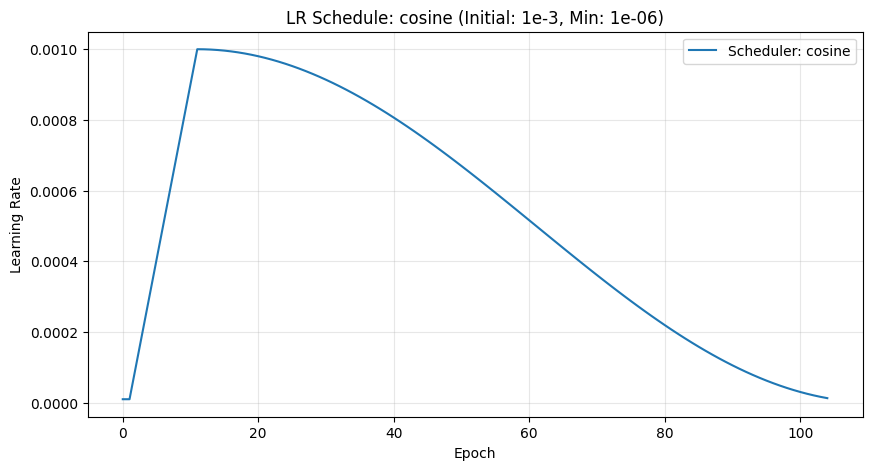

In [23]:
from argparse import Namespace
import matplotlib.pyplot as plt

# 1. Define your mock arguments
args = Namespace(
    epochs=100,
    sched='cosine',      # Options: 'cosine', 'tanh', 'step', 'plateau'
    min_lr=1e-6,
    warmup_lr=1e-5,
    warmup_epochs=10,
    cooldown_epochs=5,
    decay_rate=0.5,      # For 'step' or restart decay
    decay_epochs=20,     # For 'step'
    lr_cycle_mul=1.0,    # For 'cosine'/'tanh'
    lr_cycle_limit=1,    # Number of restarts
    lr_noise=None,       # Set to 0.05 for random jitters
    seed=42
)

# 2. Setup a dummy optimizer
dummy_param = torch.nn.Parameter(torch.zeros(1))
optimizer = torch.optim.Adam([dummy_param], lr=1e-3)

# 3. Create the scheduler
scheduler, total_epochs = create_scheduler(args, optimizer)

# 4. Simulate a training loop and record LRs
lr_history = []
for epoch in range(total_epochs):
    # Record current LR
    lr_history.append(optimizer.param_groups[0]['lr'])
    
    # Step the scheduler (usually done at the end of an epoch)
    # For Plateau, you would pass a validation metric: scheduler.step(epoch, metric=val_loss)
    scheduler.step(epoch)

# 5. Visualize the result
plt.figure(figsize=(10, 5))
plt.plot(lr_history, label=f"Scheduler: {args.sched}")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title(f"LR Schedule: {args.sched} (Initial: 1e-3, Min: {args.min_lr})")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

**Regex Tokenizer**

In [24]:
from typing import Dict, List, Tuple
class RegexTokenizer:
    def __init__(self, vocab_path: str, max_len: int = 127):
        with open(vocab_path, 'r') as f:
            vocab = [line.strip().replace('##', '') for line in f if line.strip()]
        
        self.max_len = max_len
        self.idtotok = {i: tok for i, tok in enumerate(vocab)}
        self.toktoid = {tok: i for i, tok in enumerate(vocab)}
        self.vocab_size = len(vocab)
        
        self.pad_id = self.toktoid.get('[PAD]', 0)
        self.cls_id = self.toktoid.get('[CLS]', 1)
        self.sep_id = self.toktoid.get('[SEP]', 2)

        # Build regex: match special tokens or longest chemical tokens first
        special = [r'\[CLS\]', r'\[SEP\]', r'\[PAD\]']
        chemicals = sorted([t for t in vocab if not t.startswith('[')], key=len, reverse=True)
        pattern = "(" + "|".join(special + [re.escape(t) for t in chemicals]) + ")"
        self.rg = re.compile(pattern)

    def tokenize(self, smi: str):
        return self.rg.findall(smi)

    def encode_one(self, smi: str) -> Tuple[List[int], int]:
        tokens = self.tokenize(smi.replace('[CLS]', ''))
        ids = [self.cls_id] + [self.toktoid[t] for t in tokens if t in self.toktoid] + [self.sep_id]
        
        if len(ids) > self.max_len:
            ids = ids[:self.max_len-1] + [self.sep_id]
            
        actual_len = len(ids)
        ids = ids + ([self.pad_id] * (self.max_len - len(ids)))
        return ids, actual_len

    def __call__(self, smis: List[str], truncation: str = 'max_len') -> Dict[str, torch.Tensor]:
        all_ids, all_lens = [], []
        for s in smis:
            ids, length = self.encode_one(s)
            all_ids.append(ids)
            all_lens.append(length)
            
        input_ids = torch.tensor(all_ids, dtype=torch.long)
        attention_mask = (input_ids != self.pad_id).long()
        
        if truncation == 'longest':
            m = max(all_lens)
            input_ids, attention_mask = input_ids[:, :m], attention_mask[:, :m]
            
        return {'input_ids': input_ids, 'attention_mask': attention_mask}

In [25]:
class TanhLRScheduler:
    def __init__(self, optimizer, t_initial, lb=-6., ub=4., lr_min=1e-5, warmup_t=0, warmup_lr_init=1e-6):
        self.optimizer = optimizer
        self.t_initial = t_initial
        self.lb, self.ub = lb, ub
        self.lr_min, self.warmup_t, self.warmup_lr_init = lr_min, warmup_t, warmup_lr_init
        self.base_lrs = [group['lr'] for group in optimizer.param_groups]

    def step(self, t):
        # Calculate LR based on phase
        if t < self.warmup_t:
            lr = self.warmup_lr_init + t * ((self.base_lrs[0] - self.warmup_lr_init) / self.warmup_t)
        else:
            # Clamp progress to 1.0 to avoid math errors if global_step > total_steps
            progress = min(1.0, (t - self.warmup_t) / self.t_initial)
            v = 0.5 * (1.0 - math.tanh(self.lb * (1.0 - progress) + self.ub * progress))
            lr = self.lr_min + v * (self.base_lrs[0] - self.lr_min)
        
        # Apply to optimizer
        for group in self.optimizer.param_groups:
            group['lr'] = lr
            
        return lr # MUST return this for the print statement

In [26]:
def train_ldmol(train_ds):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    vocab_path = '/kaggle/input/vocab-bpe-300/vocab_bpe_300_sc.txt'
    
    with open(vocab_path, 'r') as f:
        vocab_len = len([line for line in f if line.strip()])
    
    tokenizer = RegexTokenizer(vocab_path)
    loader = DataLoader(train_ds, batch_size=32, shuffle=True, drop_last=True)
    
    model = LDMolEncoder(vocab_size=vocab_len).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.02)
    
    total_steps = len(loader) * 5
    scheduler = TanhLRScheduler(optimizer, t_initial=total_steps, warmup_t=int(total_steps*0.05))

    print(f"Starting Training on {device} with vocab size {vocab_len}...")
    model.train()
    global_step = 0
    for epoch in range(5):
        for batch in loader:
            # Handle list or dict from train_ds
            smiles_batch = batch['smiles'] if isinstance(batch, dict) else batch
            
            view1, view2 = [], []
            for item in smiles_batch:
                parts = item.split('Q')
                # Shield RDKit by splitting 'Q' before parsing
                view1.append(augment_single_smi(parts[0]))
                target = parts[1] if len(parts) > 1 else parts[0]
                view2.append(augment_single_smi(target))
            
            t1 = tokenizer(view1, truncation='longest')
            t2 = tokenizer(view2, truncation='longest')
            
            loss = model(t1['input_ids'].to(device), t1['attention_mask'].to(device),
                         t2['input_ids'].to(device), t2['attention_mask'].to(device))
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            current_lr = scheduler.step(global_step)
            global_step += 1

            if global_step % 50 == 0:
                print(f"Epoch {epoch} | Step {global_step} | Loss {loss.item():.4f} | LR {current_lr:.2e}")
        
        # Save checkpoint after each epoch
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'epoch': epoch,
        }, f"ldmol_checkpoint_epoch_{epoch}.pt")

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from transformers import BertModel, BertConfig
from rdkit import Chem
from rdkit.Chem.EnumerateStereoisomers import EnumerateStereoisomers
import random
import re
import math
from typing import Dict, List, Tuple
from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)
import gc
torch.cuda.empty_cache()
gc.collect()
train_ldmol(train_ds)

Starting Training on cuda with vocab size 300...
Epoch 0 | Step 50 | Loss 5.6412 | LR 5.32e-05
Epoch 0 | Step 100 | Loss 5.3126 | LR 1.00e-04
Epoch 0 | Step 150 | Loss 5.7598 | LR 1.00e-04
Epoch 0 | Step 200 | Loss 5.6242 | LR 1.00e-04
Epoch 0 | Step 250 | Loss 5.5957 | LR 1.00e-04
Epoch 0 | Step 300 | Loss 5.1822 | LR 1.00e-04
Epoch 0 | Step 350 | Loss 5.2628 | LR 1.00e-04
Epoch 1 | Step 400 | Loss 4.8066 | LR 1.00e-04
Epoch 1 | Step 450 | Loss 4.9814 | LR 1.00e-04
Epoch 1 | Step 500 | Loss 5.0502 | LR 1.00e-04
Epoch 1 | Step 550 | Loss 4.4997 | LR 9.99e-05
Epoch 1 | Step 600 | Loss 4.1438 | LR 9.99e-05
Epoch 1 | Step 650 | Loss 4.5737 | LR 9.98e-05
Epoch 1 | Step 700 | Loss 3.5574 | LR 9.96e-05
Epoch 1 | Step 750 | Loss 3.9205 | LR 9.94e-05
Epoch 2 | Step 800 | Loss 4.1294 | LR 9.90e-05
Epoch 2 | Step 850 | Loss 5.5238 | LR 9.83e-05
Epoch 2 | Step 900 | Loss 4.8343 | LR 9.71e-05
Epoch 2 | Step 950 | Loss 5.3186 | LR 9.52e-05
Epoch 2 | Step 1000 | Loss 5.0289 | LR 9.21e-05
Epoch 2 | S

In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from transformers import BertModel, BertConfig, BertPreTrainedModel
from transformers.models.bert.modeling_bert import BertOnlyMLMHead
from transformers.modeling_outputs import MaskedLMOutput
import math
import re
from typing import Dict, List, Tuple
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

if 'model' in locals(): del model
if 'optimizer' in locals(): del optimizer

gc.collect()

# 3. Clear the PyTorch cache
torch.cuda.empty_cache()

# 4. Check if memory is actually free
print(f"Memory allocated: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
print(f"Memory reserved: {torch.cuda.memory_reserved() / 1e9:.2f} GB")

Memory allocated: 0.02 GB
Memory reserved: 0.04 GB


In [29]:
CONFIG = {
    "vocab_size": 300,
    "hidden_size": 768,          # Decoder width
    "encoder_width": 768,       # Encoder width
    "latent_dim": 64,            # Bottleneck dimension
    "num_hidden_layers": 12,
    "num_attention_heads": 8,
    "intermediate_size": 3072,
    "max_position_embeddings": 512,
    "batch_size": 16,
    "grad_accumulation_steps":8,
    "lr": 0.5e-4,
    "min_lr": 1e-6,
    "weight_decay": 0.02,
    "epochs": 5,
    "warmup_ratio": 0.05,
    "vocab_path": "/kaggle/input/vocab-bpe-300/vocab_bpe_300_sc.txt",
    "checkpoint_path": "/kaggle/working/ldmol_autoencoder.pt"
}

In [30]:
class BertForMaskedLM(BertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.bert = BertModel(config, add_pooling_layer=False)
        self.cls = BertOnlyMLMHead(config)
        self.init_weights()

    def forward(self, input_ids, attention_mask, encoder_hidden_states=None, encoder_attention_mask=None):
        outputs = self.bert(
            input_ids, 
            attention_mask=attention_mask, 
            encoder_hidden_states=encoder_hidden_states,
            encoder_attention_mask=encoder_attention_mask,
            return_dict=True
        )
        return self.cls(outputs.last_hidden_state)

In [31]:
class SMILESAutoencoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        enc_cfg = BertConfig(vocab_size=config["vocab_size"], hidden_size=config["encoder_width"], 
                             num_hidden_layers=12, num_attention_heads=8)
        self.encoder = BertModel(enc_cfg)
        
        # MANDATORY for 16GB GPU with 1024-width
        self.encoder.gradient_checkpointing_enable()
        
        self.encode_prefix = nn.Linear(config["encoder_width"], config["latent_dim"])
        self.decode_prefix = nn.Linear(config["latent_dim"], config["hidden_size"])

        dec_cfg = BertConfig(
            vocab_size=config["vocab_size"], hidden_size=config["hidden_size"], 
            num_hidden_layers=12, num_attention_heads=12, 
            add_cross_attention=True, is_decoder=True 
        )
        self.decoder = BertForMaskedLM(dec_cfg)
        self.decoder.bert.gradient_checkpointing_enable()

    def forward(self, input_ids, attention_mask):
        enc_state = self.encoder(input_ids, attention_mask=attention_mask).last_hidden_state
        text_embeds = self.decode_prefix(self.encode_prefix(enc_state))
        
        logits = self.decoder(
            input_ids, 
            attention_mask=attention_mask, 
            encoder_hidden_states=text_embeds,
            encoder_attention_mask=attention_mask 
        )
        
        labels = input_ids.clone()[:, 1:]
        logits = logits[:, :-1, :]
        
        loss_fct = nn.CrossEntropyLoss(ignore_index=0, reduction='sum')
        return loss_fct(logits.reshape(-1, 300), labels.reshape(-1)) / input_ids.size(0)

In [32]:
def train_autoencoder(dataset):
    device = torch.device('cuda')
    
    # CLEAR CACHE BEFORE STARTING
    torch.cuda.empty_cache()
    
    # CONFIG ADJUSTMENTS
    BATCH_SIZE = 16 
    ACCUM_STEPS = 8 
    
    tokenizer = RegexTokenizer("/kaggle/input/vocab-bpe-300/vocab_bpe_300_sc.txt")
    loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

    model = SMILESAutoencoder(CONFIG).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.5e-4)
    
    total_steps = (len(loader) // ACCUM_STEPS) * 5
    scheduler = TanhLRScheduler(optimizer, t_initial=total_steps, warmup_t=int(total_steps * 0.05))
    scaler = torch.amp.GradScaler('cuda')
    
    global_step = 0
    model.train()

    for epoch in range(5):
        optimizer.zero_grad()
        for step, batch in enumerate(loader):
            smiles = batch['smiles'] if isinstance(batch, dict) else batch
            inputs = tokenizer(smiles)
            input_ids, mask = inputs['input_ids'].to(device), inputs['attention_mask'].to(device)

            with torch.amp.autocast('cuda'):
                loss = model(input_ids, mask)
                loss = loss / ACCUM_STEPS

            scaler.scale(loss).backward()

            if (step + 1) % ACCUM_STEPS == 0:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
                
                scheduler.step(global_step)
                global_step += 1
                
                # Periodically clean up fragmentation
                if global_step % 50 == 0:
                    torch.cuda.empty_cache()

            if step % 20 == 0:
                print(f"Epoch {epoch} | Step {step} | Loss: {loss.item()*ACCUM_STEPS:.4f}")

In [33]:
if __name__ == "__main__":
    # Load your dataset here and call train_autoencoder(dataset)
    train_autoencoder(train_ds)

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Epoch 0 | Step 0 | Loss: 347.1479
Epoch 0 | Step 20 | Loss: 381.6902
Epoch 0 | Step 40 | Loss: 335.8914
Epoch 0 | Step 60 | Loss: 259.0987
Epoch 0 | Step 80 | Loss: 323.2408
Epoch 0 | Step 100 | Loss: 248.3368
Epoch 0 | Step 120 | Loss: 258.5443
Epoch 0 | Step 140 | Loss: 242.0935
Epoch 0 | Step 160 | Loss: 228.0566
Epoch 0 | Step 180 | Loss: 225.4794
Epoch 0 | Step 200 | Loss: 219.4262
Epoch 0 | Step 220 | Loss: 149.0518
Epoch 0 | Step 240 | Loss: 167.8214
Epoch 0 | Step 260 | Loss: 179.9659
Epoch 0 | Step 280 | Loss: 187.5285
Epoch 0 | Step 300 | Loss: 155.3596
Epoch 0 | Step 320 | Loss: 176.5177
Epoch 0 | Step 340 | Loss: 134.5000
Epoch 0 | Step 360 | Loss: 174.1555
Epoch 0 | Step 380 | Loss: 125.5621
Epoch 0 | Step 400 | Loss: 156.0960
Epoch 0 | Step 420 | Loss: 163.7988
Epoch 0 | Step 440 | Loss: 150.1026
Epoch 0 | Step 460 | Loss: 133.6954
Epoch 0 | Step 480 | Loss: 168.5587
Epoch 0 | Step 500 | Loss: 184.9275
Epoch 0 | Step 520 | Loss: 139.0712
Epoch 0 | Step 540 | Loss: 149.338

In [34]:
@torch.no_grad()
def infer_smiles(model, tokenizer, smis: List[str], device="cuda"):
    model.eval()
    
    # 1. Tokenize input
    inputs = tokenizer(smis)
    input_ids = inputs['input_ids'].to(device)
    mask = inputs['attention_mask'].to(device)
    
    # 2. Extract Latent Space (Encoding)
    enc_state = model.encoder(input_ids, attention_mask=mask).last_hidden_state
    latent = model.encode_prefix(enc_state)
    
    # 3. Project for Decoder (Bottleneck to Decoder width)
    text_embeds = model.decode_prefix(latent)
    
    # 4. Generate Tokens (Autoregressive decoding)
    # Start with [CLS] token
    batch_size = input_ids.size(0)
    generated = torch.full((batch_size, 1), tokenizer.cls_id, dtype=torch.long).to(device)
    
    for _ in range(tokenizer.max_len - 1):
        # We pass the currently generated tokens and the latent context
        outputs = model.decoder.bert(
            generated, 
            encoder_hidden_states=text_embeds,
            is_decoder=True,
            return_dict=True
        )
        logits = model.decoder.cls(outputs.last_hidden_state)
        
        # Pick the most likely next token
        next_token = torch.argmax(logits[:, -1, :], dim=-1, keepdim=True)
        generated = torch.cat((generated, next_token), dim=1)
        
        # If all sequences hit [SEP], we can stop early
        if (next_token == tokenizer.sep_id).all():
            break

    # 5. Convert IDs back to Strings
    decoded_smiles = []
    # Create a reverse mapping for the tokenizer
    id_to_tok = {v: k for k, v in tokenizer.toktoid.items()}
    
    for ids in generated:
        tokens = [id_to_tok[i.item()] for i in ids if i.item() not in [tokenizer.pad_id, tokenizer.cls_id, tokenizer.sep_id]]
        decoded_smiles.append("".join(tokens))
        
    return decoded_smiles